# Human Background Segmentation (To run a last time)

In [1]:
import os
import glob
import shutil
import re

1. Formating the tree

The dataset will be transformed to get a train and test folders with a 80/20 ratio.

In [2]:
def sort_data():
    train = "./train"
    test = "./test"

    gt = "ground_truth"
    img = "images"

    # Making the tree
    if not os.path.isdir(train):

        os.mkdir(train)
        os.mkdir(os.path.join(train,gt))
        os.mkdir(os.path.join(train,img))

        os.mkdir(test)
        os.mkdir(os.path.join(test,gt))
        os.mkdir(os.path.join(test,img))

    train_test_ratio = (0.8,0.2)

    A = [glob.glob("./data/Ground_Truth/*"),glob.glob("./data/Training_images/*")]
    
    # Making a list containing the path to corresponding images and ground truth
    links = []
    for i in range(len(A[0])):
        links.append((A[0][i],A[1][i]))

    train_paths = links[0:int(train_test_ratio[0] * len(links))]
    test_paths = links[int(train_test_ratio[0] * len(links)):]

    pattern_jpg = r'\\([^\\]+\.jpg)'
    pattern_png = r'\\([^\\]+\.png)'

    train_data = []
    for i in train_paths:
        if not os.path.isdir(train):
            shutil.copy2(i[0],os.path.join(train,gt))
            shutil.copy2(i[1],os.path.join(train,img))
        train_data.append((os.path.join(train,img,re.search(pattern_jpg,i[1]).group(1)),os.path.join(train,gt,re.search(pattern_png,i[0]).group(1))))

    test_data = []
    for i in test_paths:
        if not os.path.isdir(train):
            shutil.copy2(i[0],os.path.join(test,gt))
            shutil.copy2(i[1],os.path.join(test,img))
        test_data.append((os.path.join(test,img,re.search(pattern_jpg,i[1]).group(1)),os.path.join(test,gt,re.search(pattern_png,i[0]).group(1))))

    return train_data,test_data

train,test = sort_data()

In [3]:
print(train)

[('./train\\images\\1.jpg', './train\\ground_truth\\1.png'), ('./train\\images\\10.jpg', './train\\ground_truth\\10.png'), ('./train\\images\\100.jpg', './train\\ground_truth\\100.png'), ('./train\\images\\101.jpg', './train\\ground_truth\\101.png'), ('./train\\images\\102.jpg', './train\\ground_truth\\102.png'), ('./train\\images\\103.jpg', './train\\ground_truth\\103.png'), ('./train\\images\\104.jpg', './train\\ground_truth\\104.png'), ('./train\\images\\105.jpg', './train\\ground_truth\\105.png'), ('./train\\images\\106.jpg', './train\\ground_truth\\106.png'), ('./train\\images\\107.jpg', './train\\ground_truth\\107.png'), ('./train\\images\\108.jpg', './train\\ground_truth\\108.png'), ('./train\\images\\109.jpg', './train\\ground_truth\\109.png'), ('./train\\images\\11.jpg', './train\\ground_truth\\11.png'), ('./train\\images\\110.jpg', './train\\ground_truth\\110.png'), ('./train\\images\\111.jpg', './train\\ground_truth\\111.png'), ('./train\\images\\112.jpg', './train\\ground_t

2. Building our Pytorch Dataset

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets

import utils as ou 
from model import UNet

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
class HumanBackgroundSegDataset(Dataset):
    """Human Background Segmentation dataset."""

    def __init__(self, links, transform=None):
        """
        Arguments:
            links (list of tuples): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.links = links
        self.transform = transform
   
    def __len__(self):
        return len(self.links)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.links[idx][0]
        gt_name = self.links[idx][1]

        image = io.imread(img_name)
        ground_truth = io.imread(gt_name)

        sample = {'image': image, 'segmentation': ground_truth}

        if self.transform:
            sample = self.transform(sample)

        return sample


We will define our own transformations so that they could be applied to both an image and it's segmentation

In [7]:
# Classes mostly modified from the ones defined on: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

from PIL import Image

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size,seg_size):
        assert isinstance(output_size, (int, tuple))
        assert isinstance(seg_size, (int, tuple))
        self.output_size = output_size
        self.seg_size = seg_size

    def __call__(self, sample):
        image, seg = sample['image'], sample['segmentation']

        image = transform.resize(image, (self.output_size, self.output_size)) 
        
        seg = transform.resize(seg, (self.seg_size, self.seg_size))
        seg[seg>=0.5] = 1.0
        seg[seg<0.5] = 0
        return {'image': image, 'segmentation': seg}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, seg = sample['image'], sample['segmentation']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        seg = seg[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'segmentation': seg}

class RandomRotation(object):
    """Rotate randomly the image in a sample.

    Args:
        Angle (int): Rotation angle
    """

    def __init__(self, angle):
        self.angle = angle

    def __call__(self, sample):
        image, seg = sample['image'], sample['segmentation']

        # HERE ADD THE TRANSFORMATION ON BOTH THE INPUT AND THE OUTPUT
        rand_angle = np.random.randint(-self.angle, self.angle)

        image = transform.rotate(image = image, angle= rand_angle)

        seg = transform.rotate(image= seg, angle= rand_angle)

        return {'image': image, 'segmentation': seg}

class ColorJitter(object):
    def __call__(self,sample):
        image, seg = sample['image'], sample['segmentation']

        #image = Image.fromarray(255*image.astype('uint8'),mode='RGB')
        image = torch.from_numpy(image.transpose((2, 0, 1)))

        trs = transforms.ColorJitter(brightness=(0.9,1.1), contrast=(1), saturation=(0.9,1.1), hue=(-0.05,0.05))

        image = trs(image)

        return {'image': image.numpy().transpose((1,2,0)), 'segmentation': seg}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, seg = sample['image'], sample['segmentation']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W

        if len(image.shape) == 2:
            image = np.dstack((image, image, image))

        seg[seg>=0.5] = 1.0
        seg[seg<0.5] = 0
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).type(torch.float16),
                'segmentation': torch.from_numpy(seg).type(torch.float16)}

    
class Normalization(object):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std
    
    def __call__(self,sample):
        return {'image':transforms.Normalize(mean = self.mean,std = self.std)(sample['image']),'segmentation':sample['segmentation']}


image_transform = {
    'train' : transforms.Compose([
            Rescale(256,256),  
            #RandomCrop(156),
            #Rescale(256,256),    
            RandomRotation(20),
            #ColorJitter(),
            ToTensor(),
            Normalization()]),

    'test' : transforms.Compose([
            Rescale(256,256),
            ToTensor(),
            Normalization()])
}

In [8]:
train_dataset = HumanBackgroundSegDataset(train, transform = image_transform['train'])
test_dataset = HumanBackgroundSegDataset(test, transform = image_transform['test'])

Example of the augmentation of the training set (To run multiple times to see the changes)

In [9]:
data = train_dataset[0]

def plot_data(sample):

    img = torch.permute(sample['image'],[1,2,0]).numpy()
    seg = sample['segmentation'].numpy()

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 10))

    # Plot the first image on the left subplot
    axs[0].imshow(np.array(img,dtype = np.float32))
    axs[0].axis('off')
    axs[0].set_title('Image')

    # Plot the second image on the right subplot
    axs[1].imshow(np.array(seg,dtype = np.float32))
    axs[1].axis('off')
    axs[1].set_title('Corresponding Segmentation')

    # Show the plot
    plt.show()

print(data['image'])

tensor([[[-2.1191, -2.1191, -2.1191,  ..., -2.1191, -2.1191, -2.1191],
         [-2.1191, -2.1191, -2.1191,  ..., -2.1191, -2.1191, -2.1191],
         [-2.1191, -2.1191, -2.1191,  ..., -2.1191, -2.1191, -2.1191],
         ...,
         [-2.1191, -2.1191, -2.1191,  ..., -2.1191, -2.1191, -2.1191],
         [-2.1191, -2.1191, -2.1191,  ..., -2.1191, -2.1191, -2.1191],
         [-2.1191, -2.1191, -2.1191,  ..., -2.1191, -2.1191, -2.1191]],

        [[-2.0352, -2.0352, -2.0352,  ..., -2.0352, -2.0352, -2.0352],
         [-2.0352, -2.0352, -2.0352,  ..., -2.0352, -2.0352, -2.0352],
         [-2.0352, -2.0352, -2.0352,  ..., -2.0352, -2.0352, -2.0352],
         ...,
         [-2.0352, -2.0352, -2.0352,  ..., -2.0352, -2.0352, -2.0352],
         [-2.0352, -2.0352, -2.0352,  ..., -2.0352, -2.0352, -2.0352],
         [-2.0352, -2.0352, -2.0352,  ..., -2.0352, -2.0352, -2.0352]],

        [[-1.8047, -1.8047, -1.8047,  ..., -1.8047, -1.8047, -1.8047],
         [-1.8047, -1.8047, -1.8047,  ..., -1

Finally, we create the dataloaders and define the batch size used later for the training.

In [10]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

3. Defining the model and some training hyperparameters used.

In [11]:
from torchsummary import summary

#net = torch.compile(UNet(),backend = 'aot_eager').to(device) # doesn't work on windows
net = UNet().to(device)
summary(net, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
          ConvBloc-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

4. Defining the training hyperparameters: loss function, optimizer, number of epochs, learning rate. Defining the train and test loops.

BROKE DOWN. NEED TO REPAIR LIKE BEFORE

In [13]:
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics import JaccardIndex

N_epochs = 150

# Loss Function
loss_func = nn.BCEWithLogitsLoss()

# Optimizer
learning_rate = 0.001
opt = torch.optim.Adam(net.parameters(),lr = learning_rate, eps = 10**-8)

Threshold = 0.5 # To classify into background or person

met = BinaryJaccardIndex(threshold = Threshold).to(device)

patience = 10
es = ou.EarlyStopping(patience=patience)
scaler = torch.cuda.amp.GradScaler()

class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, input, target, threshold = 0.5, smooth=1):
        
        jc = JaccardIndex(task = "binary",threshold = Threshold).to(device)

        loss = 1 - jc(input, target)
                
        return loss.detach().requires_grad_(True)


# Check
loss_func2 = IoULoss().to(device)
print(met(data['segmentation'].to(device),data['segmentation'].to(device)))
print(loss_func2(data['segmentation'].to(device),data['segmentation'].to(device)))

tensor(1., device='cuda:0')
tensor(0., device='cuda:0', requires_grad=True)


In [14]:
from tqdm import tqdm
from typing import Dict, List, Tuple, Callable

# Training and testing function
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               metrics: Callable[[torch.tensor,torch.tensor],torch.tensor],
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_met = 0, 0

    loop = tqdm(enumerate(dataloader), total = len(dataloader), leave = False)
    # Loop through data loader data batches
    for batch,sample in loop:
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=True):
            X = sample["image"].to(device)
            y = sample["segmentation"].to(device)

            # 1. Forward pass
            y_pred = model(X)
            y_pred = torch.squeeze(y_pred,1)
            loss = loss_fn(input = y_pred, target = y)
            
            # THE LOSS SHOULD BE PUT BEFORE IF BCE logits, else after
            y_pred = torch.sigmoid(y_pred)
            
            # Loss and metric
            met = metrics(y_pred,y)
              
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        scaler.scale(loss).backward()

        # 5. Optimizer step
        scaler.step(optimizer)
        
        scaler.update()
        
        train_met += met.item()
        train_loss += loss.item()
        
        loop.set_postfix(loss = loss.item(), met = met.item())

    # Adjust metrics to get average loss and metric per batch
    train_loss = train_loss / len(dataloader)
    train_met = train_met / len(dataloader)
    return train_loss, train_met

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              metrics: Callable[[torch.tensor,torch.tensor],torch.tensor],
              device: torch.device) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_met = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, sample in enumerate(dataloader):
            with torch.autocast(device_type=device, dtype=torch.float16, enabled=True):
            # Send data to target device
                X = sample["image"]
                y = sample["segmentation"]

                X, y = X.to(device), y.to(device)

                # 1. Forward pass
                y_pred = model(X)
                y_pred = torch.squeeze(y_pred,1)

                loss = loss_fn(input = y_pred, target = y)

                y_pred = torch.sigmoid(y_pred)                
                met = metrics(y_pred,y)               
                        
            test_loss += loss.item()
            test_met += met.item()
    
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_met = test_met / len(dataloader)
    return test_loss, test_met

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          metrics: Callable[[torch.tensor,torch.tensor],torch.tensor],
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_met": [],
               "test_loss": [],
               "test_met": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{N_epochs}")
        train_loss, train_met = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          metrics = metrics,
                                          device=device)
        test_loss, test_met = test_step(model=model,
          dataloader=test_dataloader,
          metrics=metrics,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_met: {train_met:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_met: {test_met:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_met"].append(train_met)
        results["test_loss"].append(test_loss)
        results["test_met"].append(test_met)

        # Here we will maybe define something to early stop the training
        if es(model,results['test_loss'][epoch]):
            print(f"Early Stopping: Patience {patience} exceeded!")
            break
        
    # Return the filled results at the end of the epochs
    return results


def plot_results(dictionnary: Dict[str, List]) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    
    ax1.plot(range(len(dictionnary["train_loss"])),dictionnary["train_loss"],color ='blue',label='Training loss')
    ax1.plot(range(len(dictionnary["train_loss"])),dictionnary["test_loss"],color = 'orange',label='Test loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title("loss = f(epochs)")
    ax1.legend()

    ax2.plot(range(len(dictionnary["train_loss"])),dictionnary["train_met"],color = 'blue',label='Training metric')
    ax2.plot(range(len(dictionnary["train_loss"])),dictionnary["test_met"],color = 'orange',label='Test metric')
    ax2.set_ylim(0,1)
    ax2.set_title("acc = f(epochs)")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Metric')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

results = train(model=net,
                train_dataloader=train_loader,
                test_dataloader=test_loader,
                optimizer=opt,
                loss_fn=loss_func,
                metrics=met,
                epochs=N_epochs,
                device=device)

Epoch 1/150


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6076 | train_met: 0.2638 | test_loss: 12.2423 | test_met: 0.3739
Epoch 2/150


Epoch: 2 | train_loss: 0.5122 | train_met: 0.3155 | test_loss: 0.9453 | test_met: 0.4319
Epoch 3/150


Epoch: 3 | train_loss: 0.4951 | train_met: 0.3264 | test_loss: 0.6472 | test_met: 0.4505
Epoch 4/150


Epoch: 4 | train_loss: 0.4870 | train_met: 0.2953 | test_loss: 0.5072 | test_met: 0.4880
Epoch 5/150


Epoch: 5 | train_loss: 0.4651 | train_met: 0.3634 | test_loss: 0.6660 | test_met: 0.3534
Epoch 6/150


Epoch: 6 | train_loss: 0.4412 | train_met: 0.4174 | test_loss: 0.5103 | test_met: 0.5583
Epoch 7/150


Epoch: 7 | train_loss: 0.4324 | train_met: 0.4130 | test_loss: 0.4492 | test_met: 0.5896
Epoch 8/150


Epoch: 8 | train_loss: 0.3895 | train_met: 0.4947 | test_loss: 0.4844 | test_met: 0.5019
Epoch 9/150


Epoch: 9 | train_loss: 0.3891 | train_met: 0.4809 | test_loss: 0.4088 | test_met: 0.5763
Epoch 10/150


Epoch: 10 | train_loss: 0.3647 | train_met: 0.5102 | test_loss: 0.3720 | test_met: 0.6454
Epoch 11/150


Epoch: 11 | train_loss: 0.3467 | train_met: 0.5418 | test_loss: 0.4005 | test_met: 0.5659
Epoch 12/150


Epoch: 12 | train_loss: 0.3295 | train_met: 0.5489 | test_loss: 0.3470 | test_met: 0.6501
Epoch 13/150


Epoch: 13 | train_loss: 0.3119 | train_met: 0.5745 | test_loss: 0.3819 | test_met: 0.5718
Epoch 14/150


Epoch: 14 | train_loss: 0.3158 | train_met: 0.5740 | test_loss: 0.3510 | test_met: 0.6357
Epoch 15/150


Epoch: 15 | train_loss: 0.3169 | train_met: 0.5670 | test_loss: 0.3788 | test_met: 0.6417
Epoch 16/150


Epoch: 16 | train_loss: 0.2990 | train_met: 0.5921 | test_loss: 0.4792 | test_met: 0.4733
Epoch 17/150


Epoch: 17 | train_loss: 0.2963 | train_met: 0.5929 | test_loss: 0.3623 | test_met: 0.6589
Epoch 18/150


Epoch: 18 | train_loss: 0.2890 | train_met: 0.5981 | test_loss: 0.3950 | test_met: 0.6104
Epoch 19/150


Epoch: 19 | train_loss: 0.3016 | train_met: 0.5908 | test_loss: 0.3863 | test_met: 0.5763
Epoch 20/150


Epoch: 20 | train_loss: 0.2730 | train_met: 0.6217 | test_loss: 0.3276 | test_met: 0.6821
Epoch 21/150


Epoch: 21 | train_loss: 0.2704 | train_met: 0.6283 | test_loss: 0.4702 | test_met: 0.5746
Epoch 22/150


Epoch: 22 | train_loss: 0.2816 | train_met: 0.6118 | test_loss: 0.3730 | test_met: 0.6151
Epoch 23/150


Epoch: 23 | train_loss: 0.2700 | train_met: 0.6253 | test_loss: 0.3366 | test_met: 0.6417
Epoch 24/150


Epoch: 24 | train_loss: 0.2684 | train_met: 0.6384 | test_loss: 0.3525 | test_met: 0.6307
Epoch 25/150


Epoch: 25 | train_loss: 0.2583 | train_met: 0.6452 | test_loss: 0.3407 | test_met: 0.6312
Epoch 26/150


Epoch: 26 | train_loss: 0.2626 | train_met: 0.6356 | test_loss: 0.3216 | test_met: 0.6867
Epoch 27/150


Epoch: 27 | train_loss: 0.2452 | train_met: 0.6640 | test_loss: 0.2845 | test_met: 0.7182
Epoch 28/150


Epoch: 28 | train_loss: 0.2325 | train_met: 0.6768 | test_loss: 0.3115 | test_met: 0.7103
Epoch 29/150


Epoch: 29 | train_loss: 0.2435 | train_met: 0.6625 | test_loss: 0.4098 | test_met: 0.6011
Epoch 30/150


Epoch: 30 | train_loss: 0.2563 | train_met: 0.6329 | test_loss: 0.3504 | test_met: 0.6889
Epoch 31/150


Epoch: 31 | train_loss: 0.2480 | train_met: 0.6608 | test_loss: 0.3562 | test_met: 0.6609
Epoch 32/150


Epoch: 32 | train_loss: 0.2429 | train_met: 0.6715 | test_loss: 0.2793 | test_met: 0.7408
Epoch 33/150


Epoch: 33 | train_loss: 0.2477 | train_met: 0.6537 | test_loss: 0.3202 | test_met: 0.7014
Epoch 34/150


Epoch: 34 | train_loss: 0.2361 | train_met: 0.6548 | test_loss: 0.3731 | test_met: 0.6371
Epoch 35/150


Epoch: 35 | train_loss: 0.2405 | train_met: 0.6718 | test_loss: 0.3377 | test_met: 0.6571
Epoch 36/150


Epoch: 36 | train_loss: 0.2350 | train_met: 0.6778 | test_loss: 0.3528 | test_met: 0.6504
Epoch 37/150


Epoch: 37 | train_loss: 0.2383 | train_met: 0.6742 | test_loss: 0.3456 | test_met: 0.7068
Epoch 38/150


Epoch: 38 | train_loss: 0.2192 | train_met: 0.6996 | test_loss: 0.4116 | test_met: 0.5942
Epoch 39/150


Epoch: 39 | train_loss: 0.2228 | train_met: 0.6936 | test_loss: 0.2811 | test_met: 0.7297
Epoch 40/150


Epoch: 40 | train_loss: 0.2211 | train_met: 0.6909 | test_loss: 0.3620 | test_met: 0.6510
Epoch 41/150


Epoch: 41 | train_loss: 0.2120 | train_met: 0.7031 | test_loss: 0.3183 | test_met: 0.6809
Epoch 42/150


Epoch: 42 | train_loss: 0.2046 | train_met: 0.7102 | test_loss: 0.3196 | test_met: 0.6876
Epoch 43/150


Epoch: 43 | train_loss: 0.2001 | train_met: 0.7196 | test_loss: 0.2905 | test_met: 0.7199
Epoch 44/150


Epoch: 44 | train_loss: 0.1872 | train_met: 0.7392 | test_loss: 0.3502 | test_met: 0.6720
Epoch 45/150


Epoch: 45 | train_loss: 0.2044 | train_met: 0.7177 | test_loss: 0.3138 | test_met: 0.7133
Epoch 46/150


Epoch: 46 | train_loss: 0.1918 | train_met: 0.7298 | test_loss: 0.3111 | test_met: 0.7002
Epoch 47/150


Epoch: 47 | train_loss: 0.1971 | train_met: 0.7217 | test_loss: 0.4474 | test_met: 0.6171
Epoch 48/150


Epoch: 48 | train_loss: 0.2048 | train_met: 0.7094 | test_loss: 0.3470 | test_met: 0.6892
Epoch 49/150


Epoch: 49 | train_loss: 0.1944 | train_met: 0.7239 | test_loss: 0.3524 | test_met: 0.6515
Epoch 50/150


Epoch: 50 | train_loss: 0.1768 | train_met: 0.7566 | test_loss: 0.3173 | test_met: 0.7212
Epoch 51/150


Epoch: 51 | train_loss: 0.2055 | train_met: 0.7216 | test_loss: 0.3907 | test_met: 0.6138
Epoch 52/150


Epoch: 52 | train_loss: 0.1789 | train_met: 0.7569 | test_loss: 0.7767 | test_met: 0.0629
Epoch 53/150


Epoch: 53 | train_loss: 0.1877 | train_met: 0.7332 | test_loss: 0.5567 | test_met: 0.5896
Epoch 54/150


Epoch: 54 | train_loss: 0.1931 | train_met: 0.7347 | test_loss: 0.3278 | test_met: 0.7234
Epoch 55/150


Epoch: 55 | train_loss: 0.1792 | train_met: 0.7496 | test_loss: 0.2616 | test_met: 0.7460
Epoch 56/150


Epoch: 56 | train_loss: 0.1793 | train_met: 0.7488 | test_loss: 0.4852 | test_met: 0.5181
Epoch 57/150


Epoch: 57 | train_loss: 0.1801 | train_met: 0.7492 | test_loss: 0.3679 | test_met: 0.6694
Epoch 58/150


Epoch: 58 | train_loss: 0.1705 | train_met: 0.7660 | test_loss: 0.4020 | test_met: 0.5585
Epoch 59/150


Epoch: 59 | train_loss: 0.1907 | train_met: 0.7341 | test_loss: 0.2940 | test_met: 0.7436
Epoch 60/150


Epoch: 60 | train_loss: 0.1642 | train_met: 0.7762 | test_loss: 0.3679 | test_met: 0.6591
Epoch 61/150


Epoch: 61 | train_loss: 0.1690 | train_met: 0.7628 | test_loss: 0.2847 | test_met: 0.7372
Epoch 62/150


Epoch: 62 | train_loss: 0.1667 | train_met: 0.7617 | test_loss: 0.2730 | test_met: 0.7371
Epoch 63/150


Epoch: 63 | train_loss: 0.1487 | train_met: 0.7872 | test_loss: 0.2926 | test_met: 0.7318
Epoch 64/150


Epoch: 64 | train_loss: 0.1444 | train_met: 0.7952 | test_loss: 0.2686 | test_met: 0.7612
Epoch 65/150


Epoch: 65 | train_loss: 0.1355 | train_met: 0.8076 | test_loss: 0.3405 | test_met: 0.6819
Epoch 66/150


Epoch: 66 | train_loss: 0.1528 | train_met: 0.7830 | test_loss: 0.3007 | test_met: 0.7309
Epoch 67/150


Epoch: 67 | train_loss: 0.1524 | train_met: 0.7817 | test_loss: 0.3023 | test_met: 0.7445
Epoch 68/150


Epoch: 68 | train_loss: 0.1408 | train_met: 0.8003 | test_loss: 0.3288 | test_met: 0.7207
Epoch 69/150


Epoch: 69 | train_loss: 0.1346 | train_met: 0.8091 | test_loss: 0.3353 | test_met: 0.6984
Epoch 70/150


Epoch: 70 | train_loss: 0.1278 | train_met: 0.8162 | test_loss: 0.2583 | test_met: 0.7574
Epoch 71/150


Epoch: 71 | train_loss: 0.1299 | train_met: 0.8132 | test_loss: 0.3446 | test_met: 0.6868
Epoch 72/150


Epoch: 72 | train_loss: 0.1332 | train_met: 0.8087 | test_loss: 0.3388 | test_met: 0.7100
Epoch 73/150


Epoch: 73 | train_loss: 0.1280 | train_met: 0.8137 | test_loss: 0.2800 | test_met: 0.7524
Epoch 74/150


Epoch: 74 | train_loss: 0.1458 | train_met: 0.7976 | test_loss: 0.3247 | test_met: 0.6937
Epoch 75/150


Epoch: 75 | train_loss: 0.1451 | train_met: 0.7933 | test_loss: 0.4102 | test_met: 0.6247
Epoch 76/150


Epoch: 76 | train_loss: 0.1323 | train_met: 0.8151 | test_loss: 0.2541 | test_met: 0.7719
Epoch 77/150


Epoch: 77 | train_loss: 0.1252 | train_met: 0.8205 | test_loss: 0.3088 | test_met: 0.7466
Epoch 78/150


Epoch: 78 | train_loss: 0.1261 | train_met: 0.8189 | test_loss: 0.3985 | test_met: 0.6628
Epoch 79/150


Epoch: 79 | train_loss: 0.1198 | train_met: 0.8220 | test_loss: 0.3258 | test_met: 0.7350
Epoch 80/150


Epoch: 80 | train_loss: 0.1203 | train_met: 0.8331 | test_loss: 0.3229 | test_met: 0.7197
Epoch 81/150


Epoch: 81 | train_loss: 0.1309 | train_met: 0.8134 | test_loss: 0.3655 | test_met: 0.6953
Epoch 82/150


Epoch: 82 | train_loss: 0.1278 | train_met: 0.8152 | test_loss: 0.2863 | test_met: 0.7491
Epoch 83/150


Epoch: 83 | train_loss: 0.1181 | train_met: 0.8307 | test_loss: 0.3352 | test_met: 0.7140
Epoch 84/150


Epoch: 84 | train_loss: 0.1164 | train_met: 0.8370 | test_loss: 0.2726 | test_met: 0.7848
Epoch 85/150


Epoch: 85 | train_loss: 0.1094 | train_met: 0.8434 | test_loss: 0.2650 | test_met: 0.7569
Epoch 86/150


Epoch: 86 | train_loss: 0.1083 | train_met: 0.8439 | test_loss: 0.3979 | test_met: 0.6690
Epoch 87/150


Epoch: 87 | train_loss: 0.1266 | train_met: 0.8124 | test_loss: 0.3160 | test_met: 0.7471
Epoch 88/150


Epoch: 88 | train_loss: 0.1098 | train_met: 0.8421 | test_loss: 0.2796 | test_met: 0.7589
Epoch 89/150


Epoch: 89 | train_loss: 0.1141 | train_met: 0.8358 | test_loss: 0.6138 | test_met: 0.5221
Epoch 90/150


Epoch: 90 | train_loss: 0.1110 | train_met: 0.8398 | test_loss: 0.2954 | test_met: 0.7394
Epoch 91/150


Epoch: 91 | train_loss: 0.0993 | train_met: 0.8602 | test_loss: 0.3622 | test_met: 0.6909
Epoch 92/150


Epoch: 92 | train_loss: 0.0967 | train_met: 0.8611 | test_loss: 0.3213 | test_met: 0.7236
Epoch 93/150


Epoch: 93 | train_loss: 0.0850 | train_met: 0.8809 | test_loss: 0.3781 | test_met: 0.6930
Epoch 94/150


Epoch: 94 | train_loss: 0.0849 | train_met: 0.8781 | test_loss: 0.2890 | test_met: 0.7590
Epoch 95/150


Epoch: 95 | train_loss: 0.0881 | train_met: 0.8788 | test_loss: 0.3542 | test_met: 0.7360
Epoch 96/150


Epoch: 96 | train_loss: 0.0914 | train_met: 0.8676 | test_loss: 0.4034 | test_met: 0.6717
Epoch 97/150


Epoch: 97 | train_loss: 0.0861 | train_met: 0.8765 | test_loss: 0.3118 | test_met: 0.7410
Epoch 98/150


Epoch: 98 | train_loss: 0.0892 | train_met: 0.8733 | test_loss: 0.2983 | test_met: 0.7522
Epoch 99/150


Epoch: 99 | train_loss: 0.0899 | train_met: 0.8744 | test_loss: 0.4836 | test_met: 0.6321
Epoch 100/150


Epoch: 100 | train_loss: 0.0904 | train_met: 0.8696 | test_loss: 0.2558 | test_met: 0.7876
Epoch 101/150


Epoch: 101 | train_loss: 0.0990 | train_met: 0.8547 | test_loss: 0.3068 | test_met: 0.7523
Early Stopping: Patience 25 exceeded!


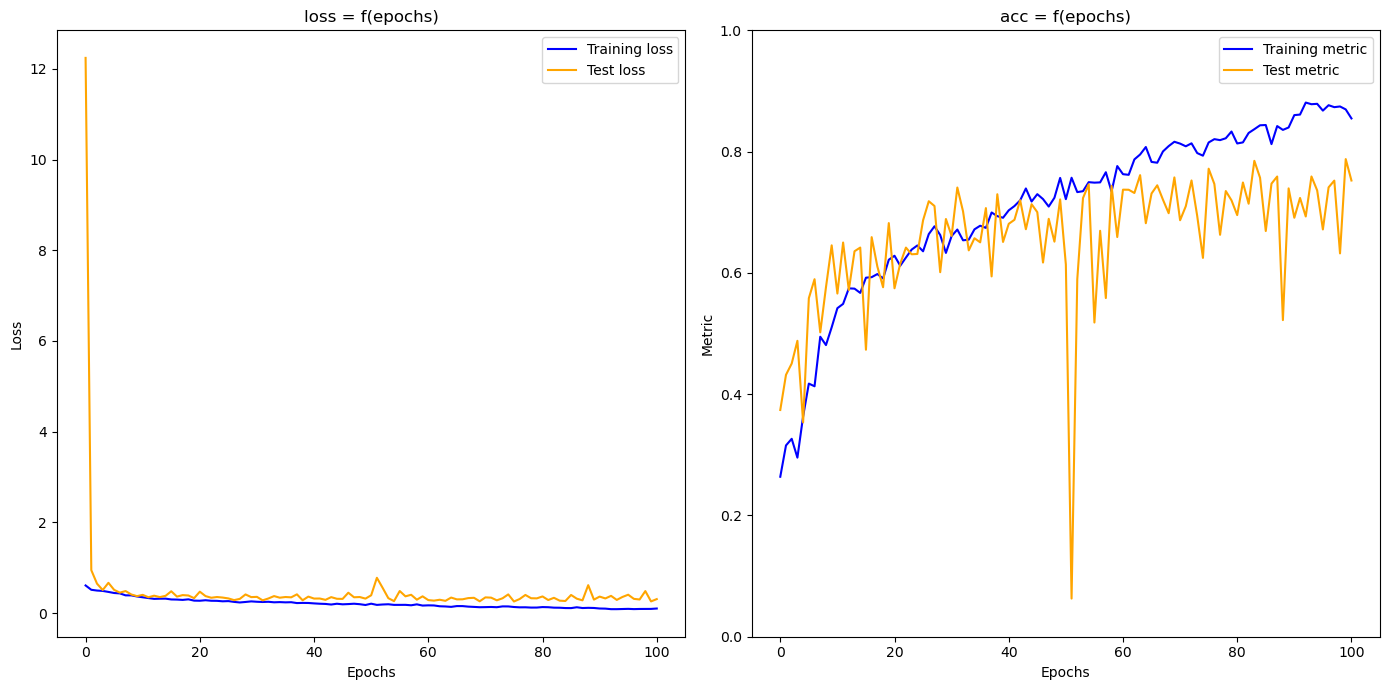

In [15]:
plot_results(results)

The training isn't going well... Probably linked to the dataset being not of a sufficient size

5. Predicting

In [ ]:
image = plt.imread("./test_image.jpg")

def predict(model,image):
  with torch.autocast(device_type=device, dtype=torch.float16, enabled=True):
    with torch.no_grad():
        size = image.shape

        image = transform.resize(image, (256, 256))
        image = torch.from_numpy(image.transpose((2, 0, 1))).type(torch.float16).to(device)
        
        tf = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        image = tf(image)

        image = torch.unsqueeze(image,0)

        pred = transform.resize(torch.sigmoid(model(image)).to('cpu').squeeze(0).squeeze(0).numpy(),(size[0],size[1]))

        pred[pred>Threshold] = 1
        pred[pred<Threshold] = 0
        return pred

plt.imshow(image)

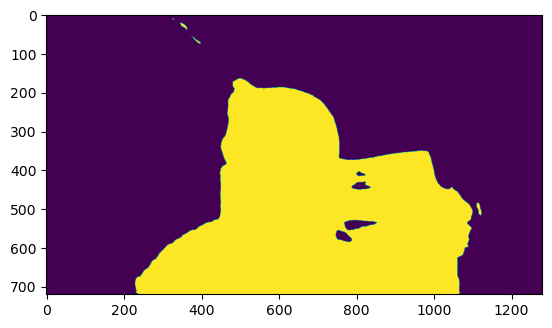

In [24]:
plt.imshow(predict(net,image))

Really weird output, same type of output gotten on the training data! --> Comes from the architecture or from the data

Some results:
- After many attempts, the ColorJitter augmentation doesn't have a benefict effect for the training. The goal by adding this transformation was for the network to learn the structure associated to a person, without associating it to a color. It didn't work as expected. It seems that the transformation over the overall color was too drastic and not realistic enough which lowered the performances of our network.
- We're quite satisfied with the results, even though it was done on a really small dataset!

6. Saving the model

In [26]:
# Saving the model to reuse it later
torch.save(net.state_dict(), "./model/state_dict")

torch.save(net,"./model/model_full.pt")

7. Loading the model to see check if everything was nicely saved

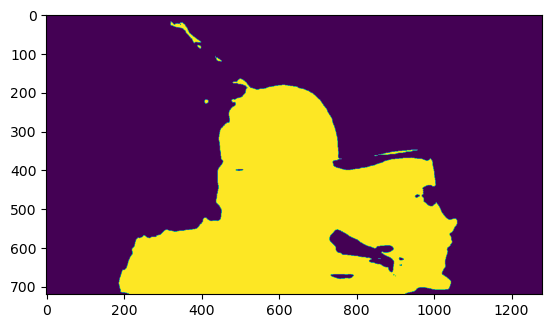

In [30]:
model = UNet().to(device)
model.load_state_dict(torch.load("./model/state_dict"))
plt.imshow(predict(model,image))

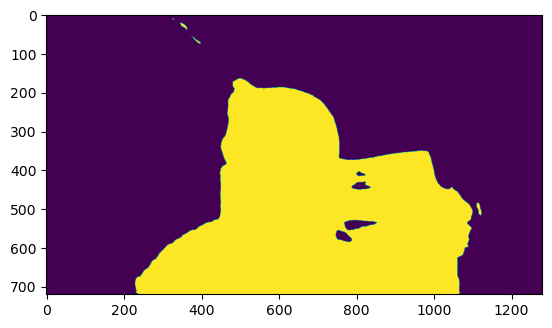

In [31]:
net1 = torch.load('./model/model_full.pt')
plt.imshow(predict(net1,image))

The model loaded from the state_dict doesn't output the expected prediction!\
Note: Add your own test image to see the prediction associated.